In [10]:
# rm(list=ls())
require(data.table)
require(MASS)
require(ggplot2)
# require(foreach)
require(gridExtra)
require(stringr)
require(matrixStats)
require(parallel)
require(abind)
require(rlist)


parallel::detectCores()
## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: rlist
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rlist’”

[1] 40

In [11]:
## POP DATA from UN
# pop <- data.table(fread("/home/j/Project/IRH/Forecasting/data/WPP_forecasted_population.csv"))
pop <- fread('/ihme/forecasting/data/pop/20150101_wpp/data.csv')
pop <- pop[, age_group_id:=15+5*(age_group_id -8)] 
pop<- pop[age_group_id == 15 | age_group_id == 20 | age_group_id == 25 | age_group_id == 30 | age_group_id == 35 | age_group_id == 40 | age_group_id == 45 | age_group_id == 50 | age_group_id == 55 | age_group_id == 60 | age_group_id == 65 | age_group_id == 70 | age_group_id == 75 | age_group_id == 85,]
head(pop)

location_id sex_id age_group_id year_id pop     
1 6           1      15           1950    27530292
2 6           1      15           1951    28008975
3 6           1      15           1952    28183766
4 6           1      15           1953    28252474
5 6           1      15           1954    28303795
6 6           1      15           1955    28343730

In [12]:
## Education forecasts
edu_orig<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/gpr_draws.csv"), header = T))
edu_orig <- edu_orig[, V1:=NULL]
head(edu_orig)
# edu<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/intermediate/gpr_draws_wide_by_years.csv"), header = T))
# edu <- data.table(edu)

Read 496860 rows and 1005 (of 1005) columns from 6.600 GB file in 00:02:06


location_id year_id age_group_id sex_id draw0    draw1    draw2    draw3   
1 6           1950    8            1      2.193899 3.696831 3.899294 5.886914
2 6           1951    8            1      2.329269 3.838159 4.045678 6.013686
3 6           1952    8            1      2.472498 3.986922 4.199735 6.134196
4 6           1953    8            1      2.623456 4.143215 4.361473 6.248749
5 6           1954    8            1      2.781863 4.307003 4.530767 6.357675
6 6           1955    8            1      2.947277 4.478090 4.707342 6.461299
  draw4    draw5    ⋯ draw990  draw991  draw992  draw993  draw994  draw995 
1 3.221693 3.998282 ⋯ 2.322269 3.697725 2.680337 3.931184 4.004720 4.729225
2 3.346715 4.065710 ⋯ 2.427470 3.836150 2.780698 3.969950 4.142245 4.905914
3 3.484166 4.133698 ⋯ 2.537848 3.977886 2.888934 4.009498 4.284303 5.089704
4 3.634715 4.203069 ⋯ 2.653360 4.122637 3.005171 4.050488 4.431217 5.279684
5 3.798821 4.274492 ⋯ 2.773895 4.270091 3.129476 4.093673 4.583275 5.474768
6 3.976678 4.348449 ⋯ 2.899285 4.419948 3.261856 4.139855 4.740723 5.673722
  draw996  draw997  draw998  draw999 
1 8.494130 2.570683 2.368506 3.664268
2 8.606566 2.687016 2.487811 3.796609
3 8.709071 2.806243 2.615149 3.934128
4 8.801838 2.928341 2.751002 4.076550
5 8.885073 3.053305 2.895764 4.223558
6 8.958986 3.181143 3.049714 4.374800

In [13]:
## Convert age_group_id to age_start
edu_orig <- edu_orig[, age_group_id:=15+5*(age_group_id -8)] 
# unique(edu_orig[,age_group_id])
edu_orig_2 <- edu_orig

## Merge pop for later stuff
edu_orig_2 <- merge(edu_orig_2, pop, by = c("location_id", "year_id", "age_group_id", "sex_id"))
head(edu_orig_2)

location_id year_id age_group_id sex_id draw0    draw1    draw2    draw3   
1 6           1950    15           1      2.193899 3.696831 3.899294 5.886914
2 6           1950    15           2      1.448223 1.717579 1.264084 2.688726
3 6           1950    20           1      3.659962 6.524635 5.061532 4.889121
4 6           1950    20           2      2.369894 3.444858 2.579920 1.316519
5 6           1950    25           1      3.671581 3.666101 4.578098 4.200772
6 6           1950    25           2      2.310831 1.251723 1.244117 2.343411
  draw4    draw5     ⋯ draw991  draw992  draw993  draw994  draw995  draw996 
1 3.221693 3.9982819 ⋯ 3.697725 2.680337 3.931184 4.004720 4.729225 8.494130
2 1.105919 2.9296499 ⋯ 1.686870 2.820281 1.765360 1.768387 1.150810 6.372643
3 3.392158 4.9910636 ⋯ 3.611764 7.242992 6.457297 2.078608 3.527786 5.901678
4 1.937400 0.6819823 ⋯ 1.725552 2.844054 2.390240 2.152858 2.072482 3.173004
5 5.551238 3.9531776 ⋯ 4.889428 4.225506 4.003180 4.758941 4.536601 3.752857
6 1.729022 2.8095801 ⋯ 2.737274 1.884835 1.863390 1.372926 1.996004 1.648636
  draw997  draw998  draw999  pop     
1 2.570683 2.368506 3.664268 27530292
2 3.671428 3.714362 1.342723 24197011
3 3.306459 4.475085 5.129506 23969500
4 1.785650 3.116931 4.983018 21357948
5 4.255601 4.350941 6.348433 20697985
6 1.170188 1.117986 1.338400 19208750

In [17]:
### For now, let's concatenatate the age and sex columns to be one identifier:
system.time(edu_orig <- edu_orig[, age_sex := paste0(age_group_id, "_", sex_id)])
edu_orig <- edu_orig[, age_group_id:= NULL]
edu_orig <- edu_orig[, sex_id:= NULL]
edu_orig <- setcolorder(edu_orig, c("location_id", "year_id", "age_sex", paste0("draw",c(0:999)) ))
head(edu_orig)

   user  system elapsed 
  0.790   0.000   0.789 

location_id year_id age_sex draw0    draw1    draw2    draw3    draw4   
1 6           1950    15_1    2.193899 3.696831 3.899294 5.886914 3.221693
2 6           1951    15_1    2.329269 3.838159 4.045678 6.013686 3.346715
3 6           1952    15_1    2.472498 3.986922 4.199735 6.134196 3.484166
4 6           1953    15_1    2.623456 4.143215 4.361473 6.248749 3.634715
5 6           1954    15_1    2.781863 4.307003 4.530767 6.357675 3.798821
6 6           1955    15_1    2.947277 4.478090 4.707342 6.461299 3.976678
  draw5    draw6    ⋯ draw990  draw991  draw992  draw993  draw994  draw995 
1 3.998282 3.933010 ⋯ 2.322269 3.697725 2.680337 3.931184 4.004720 4.729225
2 4.065710 4.017445 ⋯ 2.427470 3.836150 2.780698 3.969950 4.142245 4.905914
3 4.133698 4.106628 ⋯ 2.537848 3.977886 2.888934 4.009498 4.284303 5.089704
4 4.203069 4.201276 ⋯ 2.653360 4.122637 3.005171 4.050488 4.431217 5.279684
5 4.274492 4.302071 ⋯ 2.773895 4.270091 3.129476 4.093673 4.583275 5.474768
6 4.348449 4.409642 ⋯ 2.899285 4.419948 3.261856 4.139855 4.740723 5.673722
  draw996  draw997  draw998  draw999 
1 8.494130 2.570683 2.368506 3.664268
2 8.606566 2.687016 2.487811 3.796609
3 8.709071 2.806243 2.615149 3.934128
4 8.801838 2.928341 2.751002 4.076550
5 8.885073 3.053305 2.895764 4.223558
6 8.958986 3.181143 3.049714 4.374800

### Reshape long by draws, wide by year, use copula with spearman = 1, and reshape back AND collapse by country-year

In [18]:
# Make draws long first
system.time(edu_temp <- melt(data.table(edu_orig), id.vars = c("location_id", "age_sex", "year_id"), value.name = "edu", varnames = "draw"))
head(edu_temp)

   user  system elapsed 
  9.929   3.527  13.448 

location_id age_sex year_id variable edu     
1 6           15_1    1950    draw0    2.193899
2 6           15_1    1951    draw0    2.329269
3 6           15_1    1952    draw0    2.472498
4 6           15_1    1953    draw0    2.623456
5 6           15_1    1954    draw0    2.781863
6 6           15_1    1955    draw0    2.947277

In [21]:
## Get our baseline correlation matrix
load("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/tabulated_data/archive_nafis/insample_corr_mat.Rdata")

## For now, trim the corr matrix to have 14 age groups
corr_mat <- corr_mat[1:28,1:28]

In [22]:
corr_mat

X15_1     X15_2     X20_1     X20_2     X25_1     X25_2     X30_1    
X15_1 1.0000000 0.9732170 0.9104992 0.9046017 0.8413393 0.8303616 0.7998517
X15_2 0.9732170 1.0000000 0.9066666 0.9301547 0.8443134 0.8647346 0.8062725
X20_1 0.9104992 0.9066666 1.0000000 0.9738001 0.9625117 0.9411055 0.9339038
X20_2 0.9046017 0.9301547 0.9738001 1.0000000 0.9550482 0.9694022 0.9316304
X25_1 0.8413393 0.8443134 0.9625117 0.9550482 1.0000000 0.9732973 0.9818283
X25_2 0.8303616 0.8647346 0.9411055 0.9694022 0.9732973 1.0000000 0.9701192
X30_1 0.7998517 0.8062725 0.9339038 0.9316304 0.9818283 0.9701192 1.0000000
X30_2 0.7995524 0.8361994 0.9170183 0.9477552 0.9629529 0.9871900 0.9727286
X35_1 0.7917872 0.7982391 0.9223430 0.9223331 0.9720973 0.9639241 0.9855729
X35_2 0.7917473 0.8278405 0.9068547 0.9361865 0.9537425 0.9783820 0.9648310
X40_1 0.7823045 0.7902559 0.9129729 0.9130059 0.9623400 0.9578952 0.9782753
X40_2 0.7839885 0.8174564 0.8987753 0.9262099 0.9451906 0.9690326 0.9568560
X45_1 0.7776164 0.7848470 0.9047475 0.9065371 0.9538951 0.9503521 0.9688385
X45_2 0.7710050 0.8005395 0.8855329 0.9098966 0.9330341 0.9565441 0.9459088
X50_1 0.7681110 0.7757876 0.8935658 0.8966744 0.9422351 0.9406333 0.9579328
X50_2 0.7585391 0.7792797 0.8732258 0.8940036 0.9214687 0.9416612 0.9337220
X55_1 0.7618830 0.7669232 0.8827075 0.8857061 0.9289910 0.9301191 0.9442330
X55_2 0.7510217 0.7628309 0.8640793 0.8772571 0.9103330 0.9271694 0.9220597
X60_1 0.7482268 0.7559799 0.8732217 0.8767044 0.9207465 0.9227883 0.9353576
X60_2 0.7331851 0.7423640 0.8485870 0.8594654 0.8960389 0.9094065 0.9093810
X65_1 0.7262849 0.7337840 0.8570412 0.8589430 0.9079004 0.9054487 0.9223108
X65_2 0.7069870 0.7164053 0.8306959 0.8393110 0.8839700 0.8928053 0.8982082
X70_1 0.7197770 0.7264590 0.8484752 0.8477186 0.8977128 0.8949982 0.9103158
X70_2 0.6952294 0.7008226 0.8166672 0.8213519 0.8678577 0.8742269 0.8818344
X75_1 0.7139103 0.7176584 0.8310918 0.8304820 0.8784131 0.8759034 0.8913038
X75_2 0.6857951 0.6920926 0.8066116 0.8082242 0.8550561 0.8592598 0.8680249
X80_1 0.6995786 0.7039369 0.8159975 0.8141875 0.8601061 0.8579544 0.8703433
X80_2 0.6713990 0.6792888 0.7936400 0.7969626 0.8454362 0.8479529 0.8581746
      X30_2     X35_1     X35_2     ⋯ X60_1     X60_2     X65_1     X65_2    
X15_1 0.7995524 0.7917872 0.7917473 ⋯ 0.7482268 0.7331851 0.7262849 0.7069870
X15_2 0.8361994 0.7982391 0.8278405 ⋯ 0.7559799 0.7423640 0.7337840 0.7164053
X20_1 0.9170183 0.9223430 0.9068547 ⋯ 0.8732217 0.8485870 0.8570412 0.8306959
X20_2 0.9477552 0.9223331 0.9361865 ⋯ 0.8767044 0.8594654 0.8589430 0.8393110
X25_1 0.9629529 0.9720973 0.9537425 ⋯ 0.9207465 0.8960389 0.9079004 0.8839700
X25_2 0.9871900 0.9639241 0.9783820 ⋯ 0.9227883 0.9094065 0.9054487 0.8928053
X30_1 0.9727286 0.9855729 0.9648310 ⋯ 0.9353576 0.9093810 0.9223108 0.8982082
X30_2 1.0000000 0.9742012 0.9914609 ⋯ 0.9393929 0.9291963 0.9230729 0.9144482
X35_1 0.9742012 1.0000000 0.9728535 ⋯ 0.9460091 0.9158019 0.9287850 0.9038734
X35_2 0.9914609 0.9728535 1.0000000 ⋯ 0.9489714 0.9415432 0.9338957 0.9261148
X40_1 0.9664081 0.9842757 0.9699026 ⋯ 0.9584682 0.9277091 0.9442919 0.9146103
X40_2 0.9828915 0.9644335 0.9896377 ⋯ 0.9621156 0.9586125 0.9491411 0.9438399
X45_1 0.9606392 0.9773144 0.9664845 ⋯ 0.9684897 0.9347132 0.9537828 0.9233465
X45_2 0.9718932 0.9557398 0.9825424 ⋯ 0.9683962 0.9684193 0.9554607 0.9541549
X50_1 0.9540331 0.9662439 0.9609911 ⋯ 0.9772945 0.9446638 0.9650294 0.9334348
X50_2 0.9606607 0.9431647 0.9717198 ⋯ 0.9727664 0.9795185 0.9641065 0.9683683
X55_1 0.9447311 0.9528518 0.9542717 ⋯ 0.9826281 0.9568012 0.9731798 0.9448012
X55_2 0.9450244 0.9299471 0.9575092 ⋯ 0.9728571 0.9877973 0.9687213 0.9803701
X60_1 0.9393929 0.9460091 0.9489714 ⋯ 1.0000000 0.9685077 0.9829148 0.9593917
X60_2 0.9291963 0.9158019 0.9415432 ⋯ 0.9685077 1.0000000 0.9694623 0.9874311
X65_1 0.9230729 0.9287850 0.9338957 ⋯ 0.9829148 0.9694623 1.0000000 0.9672667
X65_2 0.9144482 0.9038734 0.9261148 ⋯ 0.9593917 0.9874311 0.9672667 1.0000000
X70_1 0.

In [23]:
## Number of countries we have to array over
countries <- unique(edu_temp[, location_id])
countries
length(countries)

[1]   6   7   8  10  11  12  13  14  15  16  17  18  19  20  22  23  24  25
 [19]  26  27  28  29  30  33  34  35  36  37  38  39  40  41  43  44  45  46
 [37]  47  48  49  50  51  52  53  54  55  57  58  59  60  61  62  63  66  67
 [55]  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87
 [73]  88  89  90  91  92  93  94  95  97  98  99 101 102 105 106 107 108 109
 [91] 110 111 112 113 114 115 116 117 118 119 121 122 123 125 126 127 128 129
[109] 130 131 132 133 135 136 139 140 141 142 143 144 145 146 147 148 149 150
[127] 151 152 153 154 155 156 157 160 161 162 163 164 165 168 169 170 171 172
[145] 173 175 176 177 178 179 180 181 182 183 184 185 186 187 189 190 191 193
[163] 194 195 196 197 198 200 201 202 203 204 205 206 207 208 209 210 211 212
[181] 213 214 215 216 217 218 298 305 349 351 376 385 422 435 522

[1] 195

In [24]:
system.time(myarray2<- mclapply(countries, 
                                function(x) {reshape2::acast(edu_temp[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ variable, 
                                                      value.var = "edu") }, mc.cores = 12))
myarray2 <- abind(myarray2, along=1)
str(myarray2)

   user  system elapsed 
457.675  16.655 474.480 

 num [1:195, 1:91, 1:28, 1:1000] 2.19 4.39 5.94 1.86 3.52 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...


In [29]:
# ### Administrative cleanup
chn_array <- myarray2

system.time(chn_array_df <- data.table::melt(chn_array))
colnames(chn_array_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")

str(chn_array)
str(chn_array_df)

   user  system elapsed 
 36.877   5.350  42.207 

 num [1:195, 1:91, 1:28, 1:1000] 2.19 4.39 5.94 1.86 3.52 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...
'data.frame':	496860000 obs. of  5 variables:
 $ location_id: int  6 7 8 10 11 12 13 14 15 16 ...
 $ year_id    : int  1950 1950 1950 1950 1950 1950 1950 1950 1950 1950 ...
 $ age_sex    : Factor w/ 28 levels "15_1","15_2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ draw_num   : Factor w/ 1000 levels "draw0","draw1",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ edu        : num  2.19 4.39 5.94 1.86 3.52 ...


### Neal's (TM) Multivariate Copula Function

In [31]:
draw2Dcopula <- function(X, cor_mat, df_return = F){
  L <- dim(X)[2]
  D <- dim(X)[3]
  Xsum <- apply(X, c(2, 3), sum)
  mvdat <- mvrnorm(n=D, mu=0 * 1:L, Sigma=cor_mat, empirical=TRUE)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sortedXsim <- apply(Xsum, 1, function(x) sort(x, index.return=TRUE)$ix)
  sortedX <- X
  for(i in 1:L){
    sortedX[,i,] <- X[,i,sortedXsim[,i]]
  }
  Xcorr <- sortedX
  for(i in 1:L){
    Xcorr[,i,] <- sortedX[,i,ranks[,i]]
  }
  if (df_return==T) {
    return(data.table(melt(Xcorr)))
    }
      else {
          Xcorr
      }
}

### Let's 2D copulate the data now

In [32]:
system.time(Xcorr_array <- mclapply(countries, 
                                    function(x) {cbind(x, draw2Dcopula(chn_array[paste0(x),,,],
                                                                      corr_mat , df_return = T))}, mc.cores = 10 ))
                                        
# Xcorr_array <-  draw2Dcopula(chn_array[1,,,], corr_mat, df_return = T)
# str(Xcorr_array)
                                        
# Xcorr_df <- list.stack(Xcorr_array, data.table=T)

 Xcorr_df <- do.call(rbind, Xcorr_array)
                                        
# system.time(Xcorr_array_binded <- melt(Xcorr_array, id.vars = c("x", "Var1", "Var2", "Var3"), value.name = "value"))
# system.time(Xcorr_array_binded <- abind(Xcorr_array, along=1))
colnames(Xcorr_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")
head(Xcorr_df)    
                                        
# correlation over our first dimension (time) remains unchanged
# time_corr <- sapply(1:28 , function(x) sapply(2:91, function(y) cor(Xcorr_array[y,x,], Xcorr_array[y-1,x,])))

# correlation over our second dimension (age) now approaches desired target
# age_corr <- sapply(2:28, function(x) sapply(1:91, function(y)   cor(Xcorr_array[y,x,], Xcorr_array[y,x-1,])))

   user  system elapsed 
 48.291 105.271 117.348 

location_id year_id age_sex draw_num edu     
1 6           1950    15_1    draw0    5.235209
2 6           1951    15_1    draw0    5.431837
3 6           1952    15_1    draw0    5.627584
4 6           1953    15_1    draw0    5.821759
5 6           1954    15_1    draw0    6.013701
6 6           1955    15_1    draw0    6.202800

In [ ]:
# Test plots (the overlays should be EXACT)
# ggplot(data = subset(chn_array_df, location_id==6 & age_sex=="15_1" & year_id==2040), aes(x=edu)) + 
#     geom_histogram(aes(y=  ..density..), alpha=0.3,fill="steelblue") +
#     geom_density(color ="blue4")   +
#     geom_histogram(data = Xcorr_df[location_id==6 &age_sex=="15_1" & year_id==2040,],  
#                    aes(x=edu, y=  ..density..), alpha=0.3,fill="red2") +
#     geom_density(color ="red4")


# ## Test for one case
# tesssst_1 <- rank_time_series(edu[location_id==102 & age_group_id==8 & sex_id==2,  6:96], corr = 1, ts = F,print=F)
# colnames(tesssst_1) <- paste0(c(1950:2040))
# tesssst_1 <- cbind(edu[location_id==6 & age_group_id==8 & sex_id==2,  1:5], tesssst_1)
# tesssst_2 <- data.table(melt(tesssst_1[, id :=NULL], id.vars=c("location_id", "age_group_id", "sex_id","variable"), value.name = "edu", variable.name = "year_id"))
# head(tesssst_1)

# ggplot(data.frame(tesssst_2)) + geom_line(aes(x=year_id, y = edu, group = variable, color=variable)) +
# theme(legend.position = "none")

### Collapse to year and country only

In [ ]:
# Reshape wide
Xcorr_df_with_pop <- dcast(Xcorr_df, location_id + year_id + age_sex ~ draw_num, value.var = c("edu"))
head(Xcorr_df_with_pop)

In [ ]:
# Split back into age and sex
Xcorr_df_with_pop2 <- Xcorr_df_with_pop
system.time({ Xcorr_df_with_pop2[, c("age_group_id","sex_id") := data.table(str_split_fixed(age_sex,"_",2))] })
Xcorr_df_with_pop2[, age_sex:=NULL]
head(Xcorr_df_with_pop2)
str(Xcorr_df_with_pop2)

In [17]:
# Merge in population
Xcorr_df_with_pop2 <- data.table(merge(x=Xcorr_df_with_pop2, y=pop, by = c("location_id", "year_id", "age_group_id", "sex_id")))
head(Xcorr_df_with_pop2)

location_id year_id age_group_id sex_id draw0     draw1     draw2    
1 10          1950    15           1      2.2503144 2.4258791 1.1211123
2 10          1950    15           2      0.3439372 0.2166051 0.5485836
3 10          1950    20           1      1.6679306 4.4186142 5.4304417
4 10          1950    20           2      1.3331527 1.5262440 1.3058459
5 10          1950    25           1      2.9277657 3.7244577 3.7516614
6 10          1950    25           2      0.6288536 1.1624769 0.6780706
  draw3     draw4     draw5     ⋯ draw991   draw992   draw993   draw994  
1 2.9242015 1.6249613 4.3722217 ⋯ 1.1827525 1.1136993 2.8482974 2.7844457
2 0.9655187 1.1025145 1.6348956 ⋯ 0.9855367 1.1710950 1.8672381 1.0122322
3 1.3993006 4.1606969 3.7461768 ⋯ 6.7339400 2.9967611 3.8523922 1.6038791
4 1.2151396 1.5229837 3.1882729 ⋯ 2.7126600 1.6881564 1.5497478 0.3214691
5 2.4002815 2.9042453 3.1279123 ⋯ 2.4163672 2.6215536 3.1071361 2.4555426
6 0.6170955 0.5761218 0.5103016 ⋯ 0.6757079 0.6771333 0.7254781 1.3144308
  draw995   draw996   draw997  draw998  draw999   pop   
1 1.4267172 1.3551591 3.563146 3.375350 2.3019833 232764
2 0.3983977 0.6597315 1.529102 1.550342 1.0178673 228276
3 1.7113836 4.7100943 9.097668 3.265435 5.5925956 201348
4 0.8733422 2.9860821 2.472405 2.102226 1.5156280 197370
5 3.1901997 2.9019956 2.544044 2.606943 3.0018018 172482
6 0.8152588 1.0786091 1.438194 0.878707 0.5890368 169320

In [18]:
# Collapse correlated data and compute the mean and PCs
Xcorr_df_CY<- Xcorr_df_with_pop2[, lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
    by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw",c(0:999))) ] 
Xcorr_df_CY <- Xcorr_df_CY[, `:=` (mean = rowMeans(.SD, na.rm=T),
                                  lower = rowQuantiles(.SD, na.rm=T, probs=c(0.025)),
                                  upper = rowQuantiles(.SD, na.rm=T, probs=c(0.975))), 
                           .SDcols = c(paste0("draw",c(0:999))) ]    
head(Xcorr_df_CY)

location_id year_id draw0    draw1    draw2    draw3    draw4    draw5   
1 10          1950    1.336208 1.678651 1.666961 1.321678 1.726451 2.100176
2 10          1951    1.363233 1.692118 1.694677 1.350223 1.766093 2.145282
3 10          1952    1.391230 1.705612 1.723597 1.380729 1.806876 2.189708
4 10          1953    1.420162 1.719183 1.753810 1.413282 1.848761 2.233337
5 10          1954    1.449966 1.732866 1.785342 1.447930 1.891650 2.276010
6 10          1955    1.480594 1.746735 1.818158 1.484754 1.935420 2.317627
  draw6    draw7    ⋯ draw993  draw994  draw995  draw996  draw997  draw998 
1 1.644592 1.935168 ⋯ 1.805843 1.324314 1.176254 1.550790 2.723640 1.806279
2 1.688327 1.959271 ⋯ 1.823794 1.364587 1.208113 1.570845 2.754895 1.836829
3 1.732409 1.983210 ⋯ 1.841873 1.406279 1.241448 1.591174 2.785191 1.867273
4 1.776700 2.007246 ⋯ 1.860134 1.449185 1.276323 1.611863 2.814625 1.897611
5 1.821005 2.031560 ⋯ 1.878600 1.493041 1.312772 1.633004 2.843222 1.927806
6 1.865190 2.056326 ⋯ 1.897400 1.537597 1.350822 1.654735 2.871037 1.957871
  draw999  mean     lower    upper   
1 2.049624 1.645919 1.068804 2.630491
2 2.107365 1.675652 1.087175 2.682010
3 2.165253 1.706197 1.111213 2.737125
4 2.223214 1.737582 1.135241 2.791019
5 2.281070 1.769783 1.160084 2.835183
6 2.338589 1.802792 1.190560 2.875104

In [19]:
# Collapse un-correlated data
uncorr_df_CY<- edu_orig_2[,lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
    by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw",c(0:999))) ] 
uncorr_df_CY <- uncorr_df_CY[, `:=` (mean = rowMeans(.SD, na.rm=T),
                              lower = rowQuantiles(.SD, na.rm=T, probs=c(0.025)),
                              upper = rowQuantiles(.SD, na.rm=T, probs=c(0.975))), 
                       .SDcols = c(paste0("draw",c(0:999))) ] 
head(uncorr_df_CY)

location_id year_id draw0    draw1    draw2    draw3    draw4    draw5   
1 6           1950    2.432078 2.713488 2.444265 2.684126 2.419469 2.592997
2 6           1951    2.510957 2.804991 2.535165 2.754107 2.496789 2.665202
3 6           1952    2.595274 2.899303 2.629450 2.825219 2.577961 2.739777
4 6           1953    2.683937 2.996656 2.726524 2.896823 2.663117 2.816964
5 6           1954    2.775488 3.097141 2.825747 2.968049 2.752269 2.896925
6 6           1955    2.869003 3.200475 2.926663 3.038625 2.845288 2.979550
  draw6    draw7    ⋯ draw993  draw994  draw995  draw996  draw997  draw998 
1 2.535412 2.335430 ⋯ 2.890653 2.466241 2.551215 3.288327 2.176167 2.639432
2 2.624748 2.420907 ⋯ 2.963955 2.546576 2.622928 3.380717 2.242943 2.730847
3 2.717568 2.510471 ⋯ 3.039806 2.631755 2.697830 3.471224 2.312788 2.826638
4 2.813468 2.603953 ⋯ 3.117165 2.721595 2.775853 3.558953 2.385391 2.925752
5 2.911723 2.701238 ⋯ 3.194826 2.815741 2.856832 3.642799 2.460515 3.026658
6 3.011781 2.802236 ⋯ 3.272223 2.913949 2.940522 3.722581 2.538353 3.128242
  draw999  mean     lower    upper   
1 2.735019 2.635495 2.221110 3.105943
2 2.831496 2.716177 2.299438 3.189553
3 2.931058 2.799702 2.374159 3.287171
4 3.032577 2.885641 2.465587 3.379080
5 3.134533 2.973364 2.557058 3.466352
6 3.235780 3.062452 2.636971 3.564466

#### Test plots

In [22]:
# Convert to arrays for super faster subsetting
system.time(myarray3<- lapply(countries, 
                                function(x) reshape2::acast(Xcorr_df[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ draw_num, 
                                                      value.var = "edu")))
myarray3 <- abind(myarray3, along=1)
str(myarray3)

   user  system elapsed 
400.692  20.453 420.963 

 num [1:195, 1:91, 1:28, 1:1000] 3.78 2.89 3.67 2.25 2.04 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw0" "draw1" "draw2" "draw3" ...


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


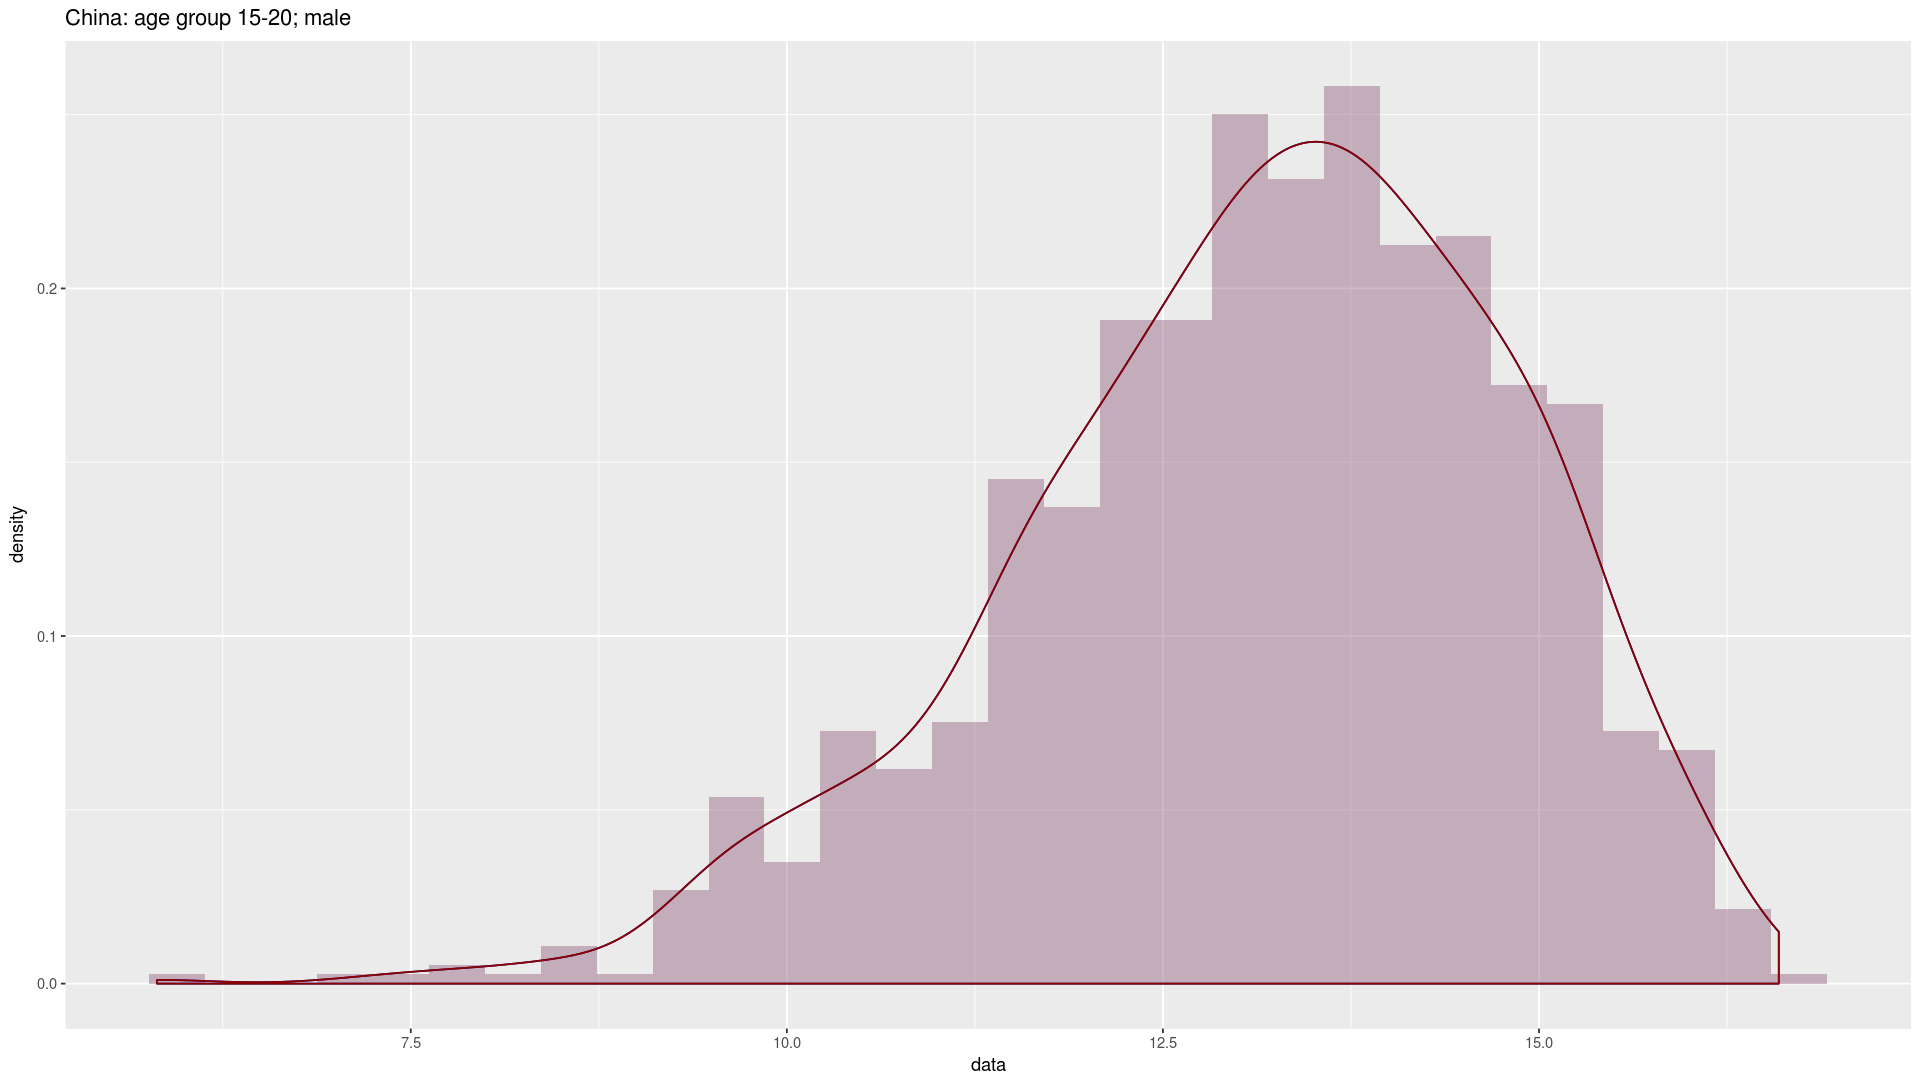

In [43]:
x1<-data.frame(myarray2["6","2040","15_1",]); colnames(x1) <- "data"
x2<-data.frame(myarray3["6","2040","15_1",]); colnames(x2) <- "data"

ggplot(data = x1, aes(x=data)) + 
    geom_histogram(aes(y=  ..density..), alpha=0.3, fill="steelblue") +
    geom_density(color ="blue4") +
geom_histogram(data = x1, aes(x=data, y=  ..density..), alpha=0.15, fill="red1") +
    geom_density(color ="red4")   + ggtitle("China: age group 15-20; male")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


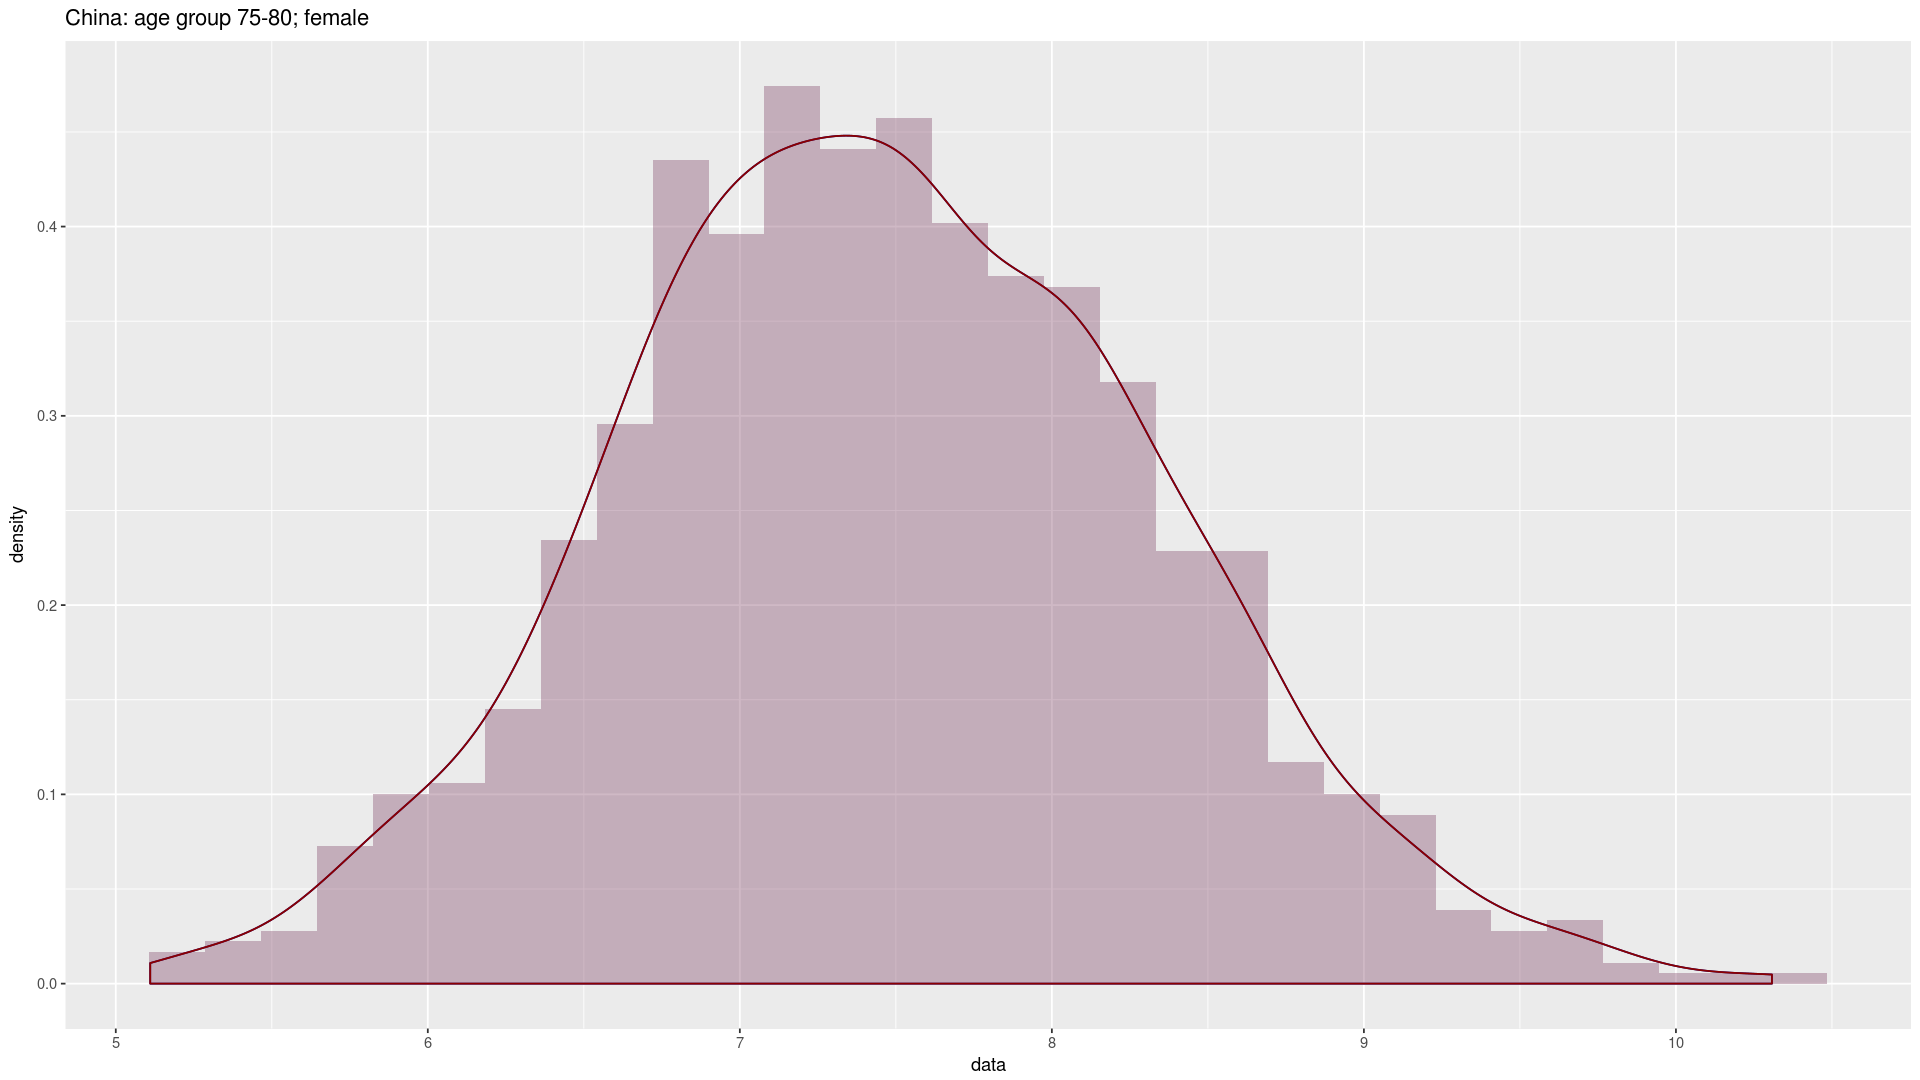

In [45]:
x1<-data.frame(myarray2["6","2040","75_2",]); colnames(x1) <- "data"
x2<-data.frame(myarray3["6","2040","75_2",]); colnames(x2) <- "data"

ggplot(data = x1, aes(x=data)) + 
    geom_histogram(aes(y=  ..density..), alpha=0.3, fill="steelblue") +
    geom_density(color ="blue4") +
geom_histogram(data = x1, aes(x=data, y=  ..density..), alpha=0.15, fill="red1") +
    geom_density(color ="red4") + ggtitle("China: age group 75-80; female")

In [28]:
## Turn the collapsed ones into arrays as well
array_Xcorr_df_CY <- melt(Xcorr_df_CY, id.vars = c("location_id", "year_id"), value.name = "edu", variable.name = "variable")
array_Xcorr_df_CY <- reshape2::acast(array_Xcorr_df_CY, location_id ~ year_id ~ variable, value.var = "edu")
str(array_Xcorr_df_CY) ### last 3 values are mean, upper, lower

array_uncorr_df_CY <- melt(uncorr_df_CY, id.vars = c("location_id", "year_id"), value.name = "edu", variable.name = "variable")
array_uncorr_df_CY <- reshape2::acast(array_uncorr_df_CY, location_id ~ year_id ~ variable, value.var = "edu")
str(array_uncorr_df_CY) ### last 3 values are mean, upper, lower

 num [1:191, 1:91, 1:1003] 2.43 2.72 3.84 1.47 1.9 ...
 - attr(*, "dimnames")=List of 3
  ..$ : chr [1:191] "6" "7" "8" "10" ...
  ..$ : chr [1:91] "1950" "1951" "1952" "1953" ...
  ..$ : chr [1:1003] "draw0" "draw1" "draw2" "draw3" ...


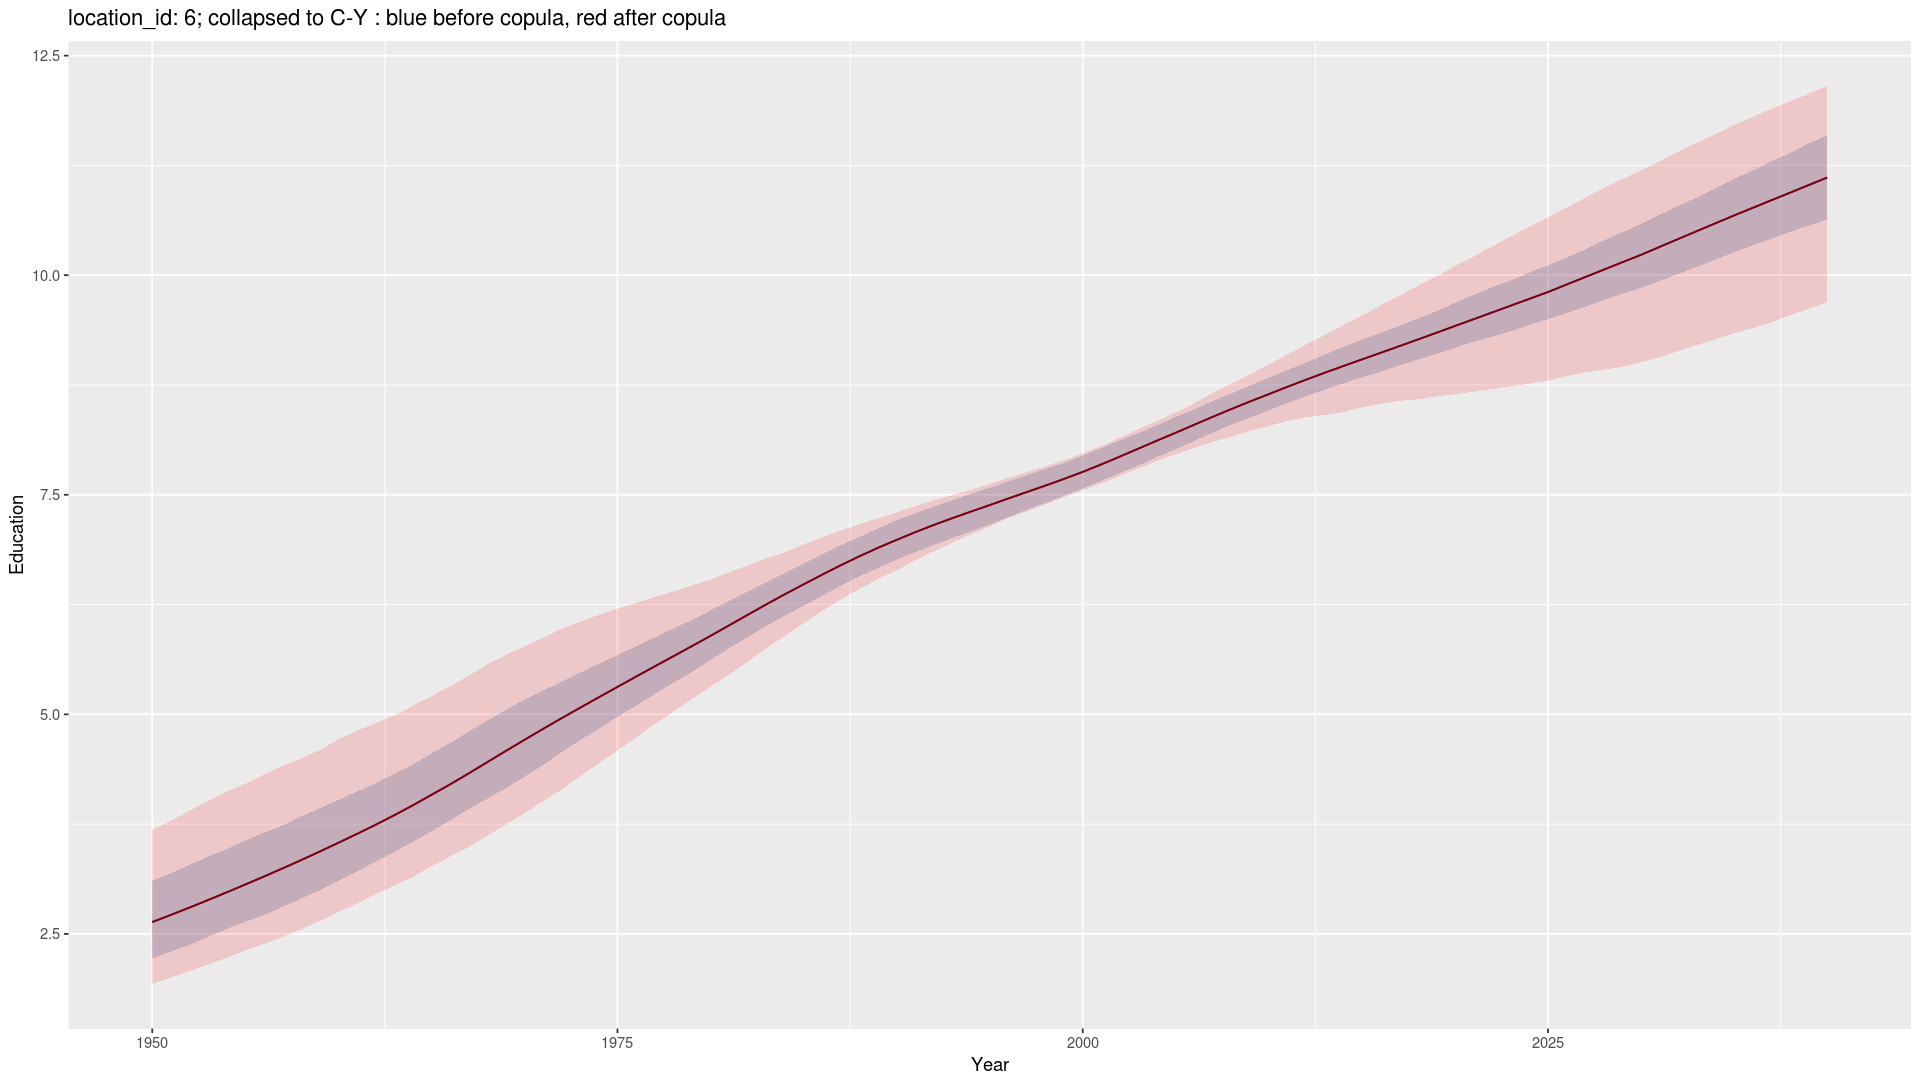

In [34]:
plot_country_collapsed<-function(loc_id) {
ggplot(uncorr_df_CY[location_id == loc_id,], aes(x = year_id, y = mean, ymin = lower, ymax = upper)) +
    geom_ribbon(alpha = 0.3, fill="steelblue") +
    geom_line(color = "blue4") +
    geom_ribbon(data=Xcorr_df_CY[location_id == loc_id,], aes(x = year_id, ymin = lower, ymax = upper),
                alpha = 0.15, fill="red1") +
    geom_line(aes(x=year_id, y=mean),color = "red4") + xlab("Year") + ylab("Education") +
    ggtitle(paste0("location_id: ", loc_id, "; collapsed to C-Y : blue before copula, red after copula"))
}

plot_country_collapsed(6)

In [46]:
## Save out data

# Collapsed C-Y
fwrite(Xcorr_df_CY, "/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/output_data/20161121_GBD2016prelim_95+_raked_2/country_year_A_S_T_collapsed.csv")

### Make country-year plots

In [35]:
filename <- paste0("/homes/sadatnfs/test_edu.pdf")
pdf(filename, width=10, height = 6)
    for(c in countries){
        print(plot_country_collapsed(c))
    }
dev.off()

png 
  2